In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import elettrocablaggi
import imgaug
import imgaug.augmenters as iaa


from mrcnn import visualize
from mrcnn import utils
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
import mrcnn.model as modellib

### Dataset location info

In [3]:
info = {'train': {'label_file_path':"../../dataset/elettrocablaggi_20200921/GRETA_230V/train/annots/labels.txt",
                   'annotation_dir': "../../dataset/elettrocablaggi_20200921/GRETA_230V/train/annots/",
                   'images_dir': "../../dataset/elettrocablaggi_20200921/GRETA_230V/train/images/"},
         'test':{'label_file_path':"../../dataset/elettrocablaggi_20200921/GRETA_230V/test/annots/labels.txt",
                   'annotation_dir': "../../dataset/elettrocablaggi_20200921/GRETA_230V/test/annots/",
                   'images_dir': "../../dataset/elettrocablaggi_20200921/GRETA_230V/test/images/"},
         'saved_model_dir': "../../weights/elettrocablaggi_20200921/"}

### Load training and test set

In [4]:
# Training dataset
dataset_train = elettrocablaggi.ElettrocablaggiDataset()
class_info, train_image_info = dataset_train.load_elettrocablaggi(info['train']['label_file_path'], 
                                                                  info['train']['annotation_dir'], 
                                                                  info['train']['images_dir'])
dataset_train.prepare()

# Validation dataset
dataset_val = elettrocablaggi.ElettrocablaggiDataset()
class_info, val_image_info = dataset_val.load_elettrocablaggi(info['test']['label_file_path'], 
                                                              info['test']['annotation_dir'], 
                                                              info['test']['images_dir'])
dataset_val.prepare()

print("Training set: ", len(train_image_info))
print("Test set: ", len(val_image_info))
print("Class info:", class_info)

Training set:  5
Test set:  0
Class info: [{'source': '', 'id': 0, 'name': 'BG'}, {'source': 'elettrocablaggi', 'id': 0, 'name': '0'}, {'source': 'elettrocablaggi', 'id': 1, 'name': '1'}, {'source': 'elettrocablaggi', 'id': 2, 'name': '2'}, {'source': 'elettrocablaggi', 'id': 3, 'name': '3'}, {'source': 'elettrocablaggi', 'id': 4, 'name': '4'}, {'source': 'elettrocablaggi', 'id': 5, 'name': '5'}, {'source': 'elettrocablaggi', 'id': 6, 'name': '6'}, {'source': 'elettrocablaggi', 'id': 7, 'name': '7'}, {'source': 'elettrocablaggi', 'id': 8, 'name': '8'}, {'source': 'elettrocablaggi', 'id': 9, 'name': '9'}, {'source': 'elettrocablaggi', 'id': 10, 'name': '10'}, {'source': 'elettrocablaggi', 'id': 11, 'name': '11'}, {'source': 'elettrocablaggi', 'id': 12, 'name': '12'}]


### Display random samples for training e validation set

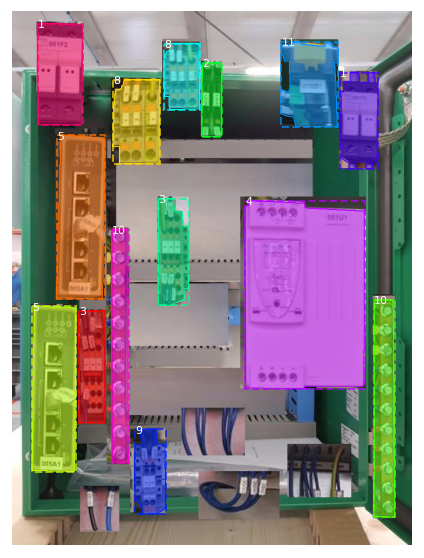

In [5]:
# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
image_ids = [0]
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_instances(image, utils.extract_bboxes(mask), mask, class_ids, 
                            dataset_train.class_names, figsize=(10, 10))

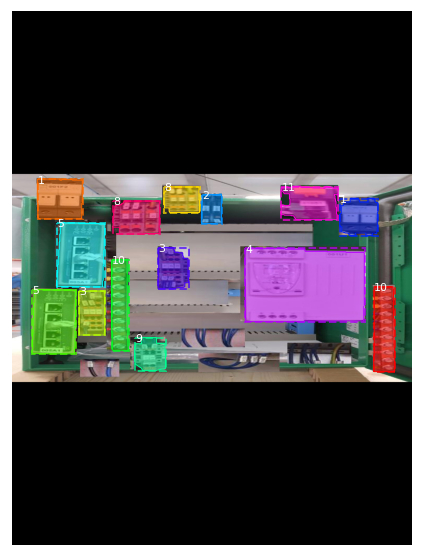

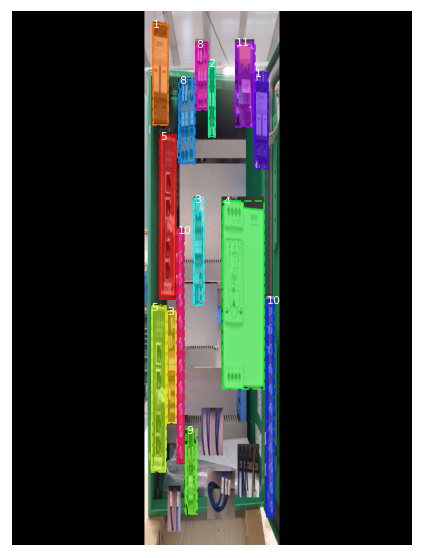

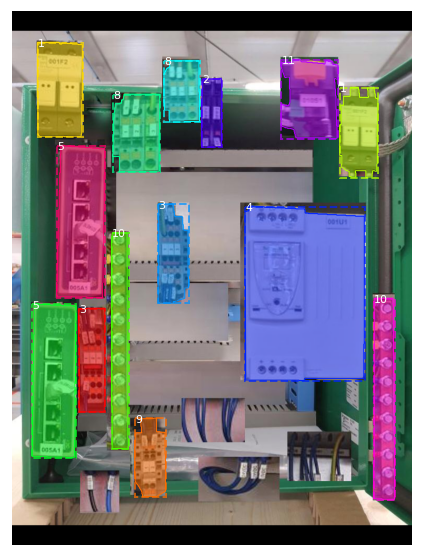

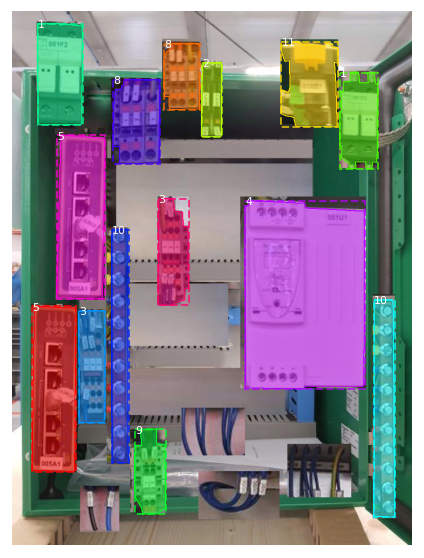

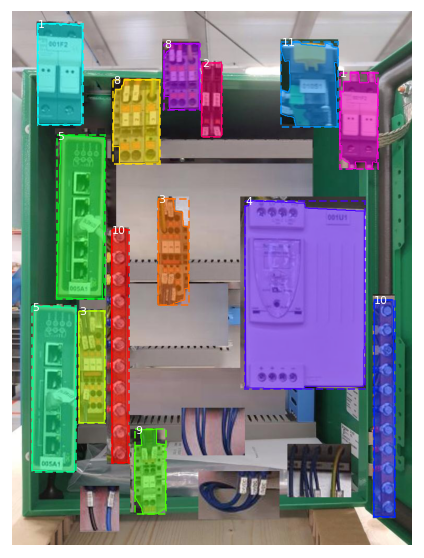

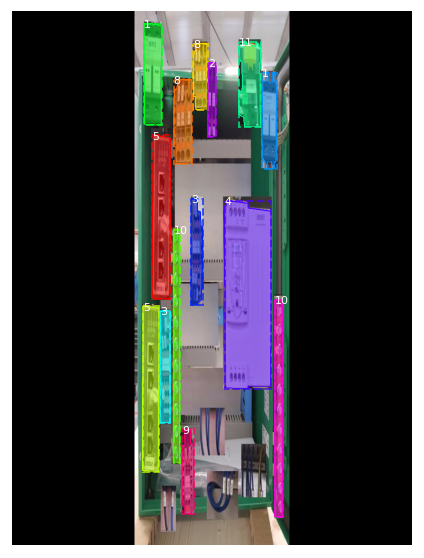

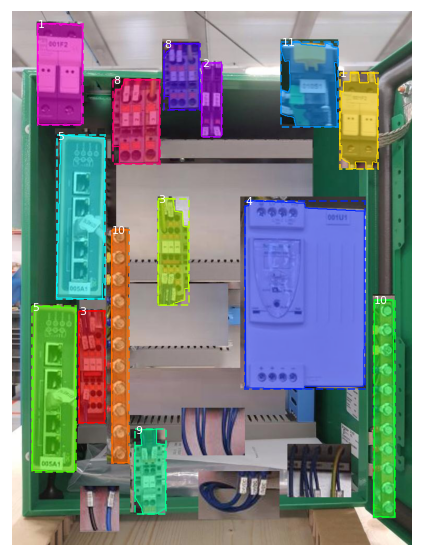

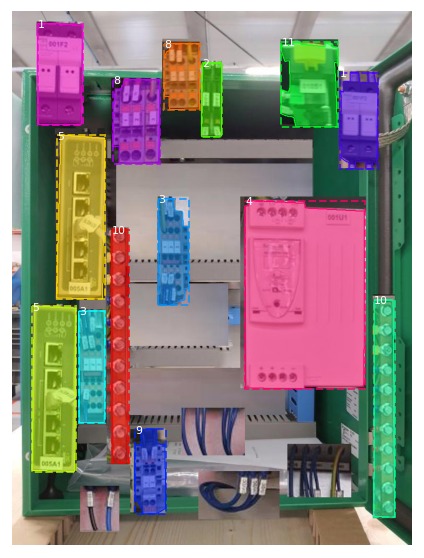

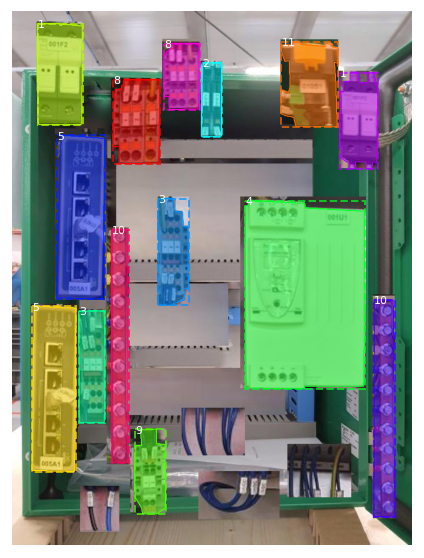

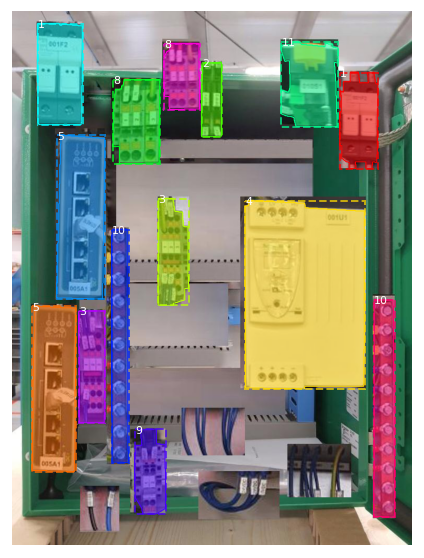

In [26]:
aug = iaa.Sometimes(0.5, iaa.OneOf([
        # iaa.Fliplr(0.25),
        # iaa.Flipud(0.25),
        iaa.GaussianBlur(sigma=(0.1, 2.0)),
        iaa.PerspectiveTransform(scale=0.03),
        iaa.ScaleX((0.25, 0.95)),
        iaa.ScaleY((0.25, 0.95)),
        ### These transformation are not tested for mask-matching yet ###
        # iaa.Rot90((1, 3)),
        # iaa.AllChannelsCLAHE(clip_limit=(1, 5), per_channel=True)
    ]))

for image_id in image_ids:
    for _ in range(10):
        det = aug.to_deterministic()

        image = dataset_train.load_image(image_id)
        mask, class_ids = dataset_train.load_mask(image_id)

        image = det.augment_image(image)
        mask = det.augment_image(mask.astype(np.uint8))
        visualize.display_instances(image, utils.extract_bboxes(mask), mask, class_ids, 
                                dataset_train.class_names, figsize=(10, 10))

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 3)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_instances(image, utils.extract_bboxes(mask), mask, class_ids, 
                            dataset_val.class_names, figsize=(10, 10))

### Diplay model config for training

In [6]:
# Create config class containing training properties
config = elettrocablaggi.ElettrocablaggiConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                26
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

### Load trainend weight

In [7]:
inference_config = elettrocablaggi.ElettrocablaggiInferenceConfig()

# create the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=info['saved_model_dir'])

# Get path of saved weights
model_path = model.find_last()
prediction_dir = '/'.join(model_path.split('/')[:-1])
print("Directory of infered images: ", prediction_dir)







Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Directory of infered images:  ../../weights/elettrocablaggi_20200921


### Display prediction

In [8]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return fig, ax


In [9]:
images = glob.glob(os.path.join(prediction_dir, 'elettrocablaggi20201224T2241','prediction', '*.jpg'))
print(images)

['../../weights/elettrocablaggi_20200921\\elettrocablaggi20201224T2241\\prediction\\20200921_101722.jpg']


In [10]:
samples = 1
random = True
replace = False

if random:
    image_ids = np.random.choice(len(images), samples, replace=replace)
else:
    image_ids = images

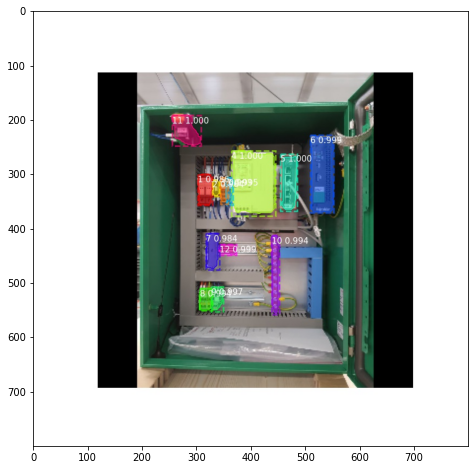

In [11]:
for i in image_ids:
    img = mpimg.imread(images[i])
    fig, ax = get_ax()
    imgplot = ax.imshow(img)